# Imports

In [491]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [492]:
data = getRelativeStockData('AAPL', '2020-01-01')
scrollData(data).columns

[*********************100%***********************]  1 of 1 completed


Index(['SolutionClose1', 'SolutionClose2', 'SolutionClose3', 'ContextOpen0',
       'ContextOpen-1', 'ContextOpen-2', 'ContextOpen-3', 'ContextOpen-4',
       'ContextOpen-5', 'ContextOpen-6', 'ContextOpen-7', 'ContextOpen-8',
       'ContextOpen-9', 'ContextHigh0', 'ContextHigh-1', 'ContextHigh-2',
       'ContextHigh-3', 'ContextHigh-4', 'ContextHigh-5', 'ContextHigh-6',
       'ContextHigh-7', 'ContextHigh-8', 'ContextHigh-9', 'ContextLow0',
       'ContextLow-1', 'ContextLow-2', 'ContextLow-3', 'ContextLow-4',
       'ContextLow-5', 'ContextLow-6', 'ContextLow-7', 'ContextLow-8',
       'ContextLow-9', 'ContextClose0', 'ContextClose-1', 'ContextClose-2',
       'ContextClose-3', 'ContextClose-4', 'ContextClose-5', 'ContextClose-6',
       'ContextClose-7', 'ContextClose-8', 'ContextClose-9',
       'ContextAdj Close0', 'ContextAdj Close-1', 'ContextAdj Close-2',
       'ContextAdj Close-3', 'ContextAdj Close-4', 'ContextAdj Close-5',
       'ContextAdj Close-6', 'ContextAdj Close-7

# Helper Functions

In [493]:
def getRelativeStockData(ticker, start, end="2024-2-2", interval="1d"):
    data = yf.download(ticker, start=start, end=end, interval=interval)

    # Making it relative to the previous data point with 1% = 0.01
    # All in a pandas dataframe

    # Only use the close price
    # data = data["Close"]
    
    data = data.pct_change().dropna()
    data = data.reset_index()
    data = data.rename(columns={"index": "Date"})


    return data


def scrollData(data, contextWindow=10, solutionWindow=3):
    """
    Scroll through the data and return the context window and the solution window for all columns.

    Parameters:
    - data (pandas.DataFrame): The input data.
    - contextWindow (int): The size of the context window.
    - solutionWindow (int): The size of the solution window.

    Returns:
    - scrolledData (pandas.DataFrame): The scrolled data with updated column names.
    """

    # Create the solution columns only for Close (what to predict)
    # This is before the general loop to make it the first columns
    for i in range(solutionWindow):
        data[f"Solution{'Close'}{i+1}"] = data["Close"].shift(-i)

    # Create the columns for the context and solution windows
    for col in data.columns:
        if col != "Date" and not "Solution" in col:
            # Create the context columns for all columns
            for i in range(contextWindow):
                data[f"Context{col}{-i}"] = data[col].shift(i)

    # Drop the NaN values
    data = data.dropna()

    # Drop the original columns
    data = data.drop(columns=data.columns[:7])

    # Fix the index
    data = data.reset_index(drop=True)

    return data


def unrelativizeDataArray(data):
    # Unrelativize the data
    # This is done by multiplying the previous data point with the current data point
    # This is done for all values except the first

    processedData = data.copy()

    # Its an array in an array for some reason (with predictions)
    if len(processedData) == 1:
        processedData = processedData[0]

    # Make the base (first value) 0
    processedData[0] = 0

    # Loop through the data and unrelativize it
    for i in range(len(processedData)):
        if i != 0:
            processedData[i] = (processedData[i] + 1) * (processedData[i-1] + 1) - 1

    return processedData


# TODO: Give the training data market context via this function
# def getRelativeStockDataWithContext(ticker, marketContextTickers, start, end="2024-2-2", interval="1d", contextWindow=10, solutionWindow=3):
#     # This function will get the relative stock data 
#     # and then append the context columns for each market context ticker
#     # 
    

# Prepare Data

In [617]:
# Get Data for AAPL
data = getRelativeStockData("AAPL", "2020-1-1", interval="1d")

# Some Parameters
contextWindow=300
solutionWindow=30

# Scroll the data
data = scrollData(data, contextWindow=contextWindow, solutionWindow=solutionWindow)

# Remove any inf values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Split the data into training and testing data
train, test = train_test_split(data, test_size=0.1)

# Columns for the context and solution windows
contextColumns = data.columns[solutionWindow:]
solutionColumns = data.columns[:solutionWindow]

# Split X and y
X_train = train[contextColumns]
y_train = train[solutionColumns]

X_test = test[contextColumns]
y_test = test[solutionColumns]

[*********************100%***********************]  1 of 1 completed


/var/folders/4f/1_x0p0d95fg8j5jdc43b1s9c0000gn/T/ipykernel_22789/2397548564.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"Context{col}{-i}"] = data[col].shift(i)
/var/folders/4f/1_x0p0d95fg8j5jdc43b1s9c0000gn/T/ipykernel_22789/2397548564.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"Context{col}{-i}"] = data[col].shift(i)
/var/folders/4f/1_x0p0d95fg8j5jdc43b1s9c0000gn/T/ipykernel_22789/2397548564.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

# Train the Model

In [625]:
# Making the MLP model
# model = MLPRegressor(hidden_layer_sizes=(1), max_iter=100, verbose=True)
model = MLPRegressor(hidden_layer_sizes=(250, 50, 250, 10), activation='relu', solver='adam', alpha=0.0001, learning_rate='constant', learning_rate_init=0.001, verbose=True, tol=0.000000001, max_iter=500)


# Train the model
model.fit(X_train, y_train)

Iteration 1, loss = 0.01946297
Iteration 2, loss = 0.01650610
Iteration 3, loss = 0.01554670
Iteration 4, loss = 0.01448187
Iteration 5, loss = 0.01355638
Iteration 6, loss = 0.01256976
Iteration 7, loss = 0.01166557
Iteration 8, loss = 0.01075757
Iteration 9, loss = 0.00990274
Iteration 10, loss = 0.00906694
Iteration 11, loss = 0.00827709
Iteration 12, loss = 0.00752284
Iteration 13, loss = 0.00681290
Iteration 14, loss = 0.00614585
Iteration 15, loss = 0.00552333
Iteration 16, loss = 0.00494478
Iteration 17, loss = 0.00441035
Iteration 18, loss = 0.00392041
Iteration 19, loss = 0.00347366
Iteration 20, loss = 0.00306912
Iteration 21, loss = 0.00270676
Iteration 22, loss = 0.00238334
Iteration 23, loss = 0.00209664
Iteration 24, loss = 0.00184466
Iteration 25, loss = 0.00162355
Iteration 26, loss = 0.00143077
Iteration 27, loss = 0.00126246
Iteration 28, loss = 0.00111639
Iteration 29, loss = 0.00098976
Iteration 30, loss = 0.00088068
Iteration 31, loss = 0.00078690
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(250, 50, 250, 10), max_iter=500, tol=1e-09,
             verbose=True)

# Test the Model

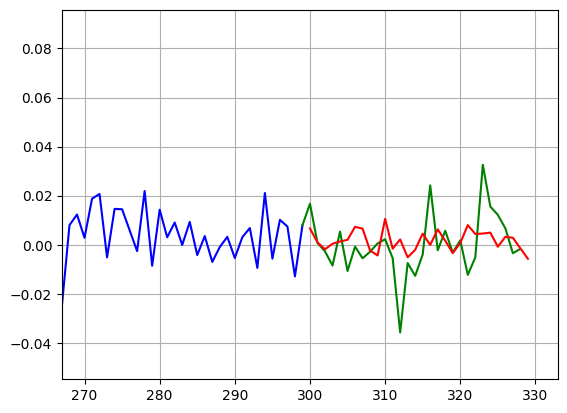

In [701]:
# Get the x'th data point for testing
whereToPredict = 5 # points before end
contextToPredict = data[contextColumns][-1-whereToPredict:-whereToPredict]
solutionToPredict = data[solutionColumns][-1-whereToPredict:-whereToPredict]

# Make Prediction on that data point
predicitons = model.predict(contextToPredict)


# Make the data usefull (reversing etc.)
plottedContext = contextToPredict.iloc[:, 3*contextWindow:4*contextWindow].values[0][::-1].reshape(-1, 1)
plottedSolution = solutionToPredict.values.reshape(-1, 1)
plottedPredictions = predicitons.reshape(-1, 1)

# Plot the data in green, red, blue
plt.plot(plottedContext, "blue")

x_values = range(contextWindow - 1, contextWindow + len(plottedSolution) - 1)
plt.plot(x_values, plottedSolution, "green")

x_values = range(contextWindow, contextWindow + len(plottedPredictions))
plt.plot(x_values, plottedPredictions, "red")

# Set the x-axis range to zoom from ... to ...
plt.xlim(len(unrelativizeDataArray(plottedContext))-len(unrelativizeDataArray(plottedPredictions))*1.1, len(unrelativizeDataArray(plottedContext)) + len(unrelativizeDataArray(plottedPredictions)) * 1.1)

plt.grid()

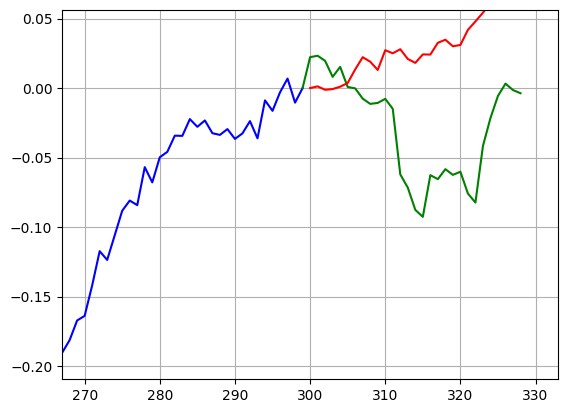

In [702]:
# Plot the data in green, red, blue
plt.plot(unrelativizeDataArray(plottedContext) - unrelativizeDataArray(plottedContext)[-1], "blue")

x_values = range(contextWindow - 1, contextWindow + len(plottedSolution) - 1)
y_values = unrelativizeDataArray(plottedSolution) * (unrelativizeDataArray(plottedContext)[-1] + 1)
plt.plot(x_values, y_values , "green")

x_values = range(contextWindow, contextWindow + len(plottedPredictions))
y_values = unrelativizeDataArray(plottedPredictions) * (unrelativizeDataArray(plottedContext)[-1] + 1)
plt.plot(x_values, y_values, "red")

# Set the x-axis range to zoom from ... to ...
xlim = len(unrelativizeDataArray(plottedContext))-len(unrelativizeDataArray(plottedPredictions))*1.1, len(unrelativizeDataArray(plottedContext)) + len(unrelativizeDataArray(plottedPredictions)) * 1.1
plt.xlim(xlim)

# Set the y-axis range to zoom from the minimum to the maximum of all values visible in the plot
allValuesInPlot = np.append(unrelativizeDataArray(plottedPredictions), unrelativizeDataArray(plottedSolution))
allValuesInPlot = np.append(allValuesInPlot, (unrelativizeDataArray(plottedContext) - unrelativizeDataArray(plottedContext)[-1])[int(xlim[0]):int(xlim[1])])

plt.ylim(min(allValuesInPlot)*1.1, max(allValuesInPlot)*1.1)

plt.grid()

# Calculating some fancy stats

In [703]:
# Average percent error calculation
# First we'll calculate the percentage error between all the predictions and the actual values
# Then we'll calculate the average of those percentage errors

# Average absolute error calculation
# First we'll calculate the absolute error between all the predictions and the actual values
# Then we'll calculate the average of those absolute errors

avgPercentErrors = []
avgAbsoluteErrors = []


for i in range(len(plottedPredictions)):
    percentError = abs((plottedPredictions[i] - plottedSolution[i]) / plottedSolution[i]) # 1% = 0.01
    avgPercentErrors.append(percentError)

    absoluteError = abs(plottedPredictions[i] - plottedSolution[i])
    avgAbsoluteErrors.append(absoluteError)

In [704]:
# Calculate the average of the errors
avgPercentError = (sum(avgPercentErrors) / len(avgPercentErrors))[0]
avgAbsoluteError = (sum(avgAbsoluteErrors) / len(avgAbsoluteErrors))[0]

In [705]:
# Sum up with print statements
print(f"Average percent error: {round(avgPercentError*100, 2)}%")
print(f"Average absolute error: {round(avgAbsoluteError*100, 2)}%")

Average percent error: 214.45%
Average absolute error: 0.92%


# Some actually professional measures

In [706]:
# Predict the Testing Data
predicitons = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predicitons)

# Print the mean squared error
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.00036336258278092605
